<h1>Package Installation<h1>

In [2]:
# import os

# def install_packages():
#     packages = [
#         "nltk",
#         "scikit-learn",
#         "pyLDAvis",
#         "gensim",
#         "matplotlib",
#         "wordcloud",
#         "seaborn",
#         "pandas",
#         "numpy",
#     ]
#     for package in packages:
#         os.system(f"pip install {package}")

# install_packages()



<h1>Importing All Libraries</h1>

In [1]:
import nltk
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt')
import re
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation, NMF
import pyLDAvis
import numpy as np
import time
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\farha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\farha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\farha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<h1>Loading Data</h1>

In [2]:
# loading data

try:
    all_data = pd.read_csv('english_hate_speech.csv')
    all_data.head()
except Exception as e:
    print(f"Error loading data: {e}")

print("Shape of the data: ", all_data.shape) #inspecting the shape of the data


Shape of the data:  (14490, 4)


<h1>Data Preprocessing</h1>

<h3>Missing Values</h3>

In [3]:
# check missing value count
missing_values_count = all_data.isna().sum()
print(missing_values_count)
print("\n")
# As only 8 missing values, dropping these rows
all_data.dropna(subset=['clean_text'], inplace=True)

# checking missing values again
print("Checking missing value after dropping data")
missing_values_count = all_data.isna().sum()
print(missing_values_count)


Text          0
oh_label      0
Dataset       0
clean_text    8
dtype: int64


Checking missing value after dropping data
Text          0
oh_label      0
Dataset       0
clean_text    0
dtype: int64


<h3>Tokenizing the Clean Text Column</h3>

In [4]:
def tokenise_text(data):
    """
    Tokenise the text in the clean_text column
    """
    try:
        # label changed to a float when imported, changing it back
        data['oh_label'] = data['oh_label'].astype(int)
        data['clean_text'] = data['clean_text'].astype(str)

        # also lowercasing all words
        data['tokens'] = data['clean_text'].apply(lambda x: [word.lower() for word in x.split()]) #ensures all text is lowercase
        print("Tokenisation successful")
        return data
    except Exception as e:
        print(f"Tokenisation error: {e}")
        return None

all_data = tokenise_text(all_data)
all_data.head()

Tokenisation successful


,Text,oh_label,Dataset,clean_text,tokens
0,I give permission for Wikipedia to use the ...,0,aggression_parsed_dataset_subset.csv,give permission Wikipedia use material Nancy S...,"[give, permission, wikipedia, use, material, n..."
1,` October 2010 (UTC) :::::It does look that wa...,0,toxicity_parsed_dataset_subset.csv,October 2010 UTC look way merger sounds like C...,"[october, 2010, utc, look, way, merger, sounds..."
2,RT @dcm81: #killerblondes ?? Have the producer...,0,twitter_parsed_dataset_subset.csv,RT dcm81 killerblondes producers lost plot eye...,"[rt, dcm81, killerblondes, producers, lost, pl..."
3,@ShaofHappiness COME SAY HI TO ME THIS EVENING...,0,twitter_parsed_dataset_subset.csv,ShaofHappiness COME SAY HI EVENING ILU,"[shaofhappiness, come, say, hi, evening, ilu]"
4,"@ManhattaKnight I mean he's gay, but he uses g...",1,cyberbullying_tweets_subset.csv,ManhattaKnight mean hes gay uses gendered slur...,"[manhattaknight, mean, hes, gay, uses, gendere..."


<h3>Lemmatize the Tokenized Texts Column</h3>

In [5]:

def lemmatize_text(data):
    """
    Lemmatises the tesxt data
    """
    try:
        lemm = WordNetLemmatizer() #using the inbuilt lemmatisation function

    # Lemmatize all words
        data['lemmatized'] = data['tokens'].apply(lambda x: [lemm.lemmatize(word) for word in x])
        print("Lemmatisation successful")
        return data
    except Exception as e:
        print(f"An error occurred during lemmatisation: {e}")
        return data

all_data=lemmatize_text(data=all_data)
all_data.head()

Lemmatisation successful


,Text,oh_label,Dataset,clean_text,tokens,lemmatized
0,I give permission for Wikipedia to use the ...,0,aggression_parsed_dataset_subset.csv,give permission Wikipedia use material Nancy S...,"[give, permission, wikipedia, use, material, n...","[give, permission, wikipedia, use, material, n..."
1,` October 2010 (UTC) :::::It does look that wa...,0,toxicity_parsed_dataset_subset.csv,October 2010 UTC look way merger sounds like C...,"[october, 2010, utc, look, way, merger, sounds...","[october, 2010, utc, look, way, merger, sound,..."
2,RT @dcm81: #killerblondes ?? Have the producer...,0,twitter_parsed_dataset_subset.csv,RT dcm81 killerblondes producers lost plot eye...,"[rt, dcm81, killerblondes, producers, lost, pl...","[rt, dcm81, killerblondes, producer, lost, plo..."
3,@ShaofHappiness COME SAY HI TO ME THIS EVENING...,0,twitter_parsed_dataset_subset.csv,ShaofHappiness COME SAY HI EVENING ILU,"[shaofhappiness, come, say, hi, evening, ilu]","[shaofhappiness, come, say, hi, evening, ilu]"
4,"@ManhattaKnight I mean he's gay, but he uses g...",1,cyberbullying_tweets_subset.csv,ManhattaKnight mean hes gay uses gendered slur...,"[manhattaknight, mean, hes, gay, uses, gendere...","[manhattaknight, mean, he, gay, us, gendered, ..."


<h3>Preprocessing Data</h3>

In [6]:
def remove_numbers(word_list):
    """
    removees any numbers from the text
    """
    return [word for word in word_list if not bool(re.search(r'\d', word))]

# Function to remove URLs from a list of words
def remove_urls(word_list):
    """
    Removes any URLs from the text
    """
    return [word for word in word_list if not (word.startswith('http') or word.startswith('www') or word.startswith('https'))]

all_data['lemmatized_no_numbers'] = all_data['lemmatized'].apply(remove_numbers)
all_data['lemmatized_clean'] = all_data['lemmatized_no_numbers'].apply(remove_urls)

all_data['tokenized_clean']=all_data['tokens'].apply(remove_numbers)
all_data['tokenized_clean']=all_data['tokenized_clean'].apply(remove_urls)
all_data['string_tokenized']=all_data['tokenized_clean'].apply(' '.join)
all_data.head()

,Text,oh_label,Dataset,clean_text,tokens,lemmatized,lemmatized_no_numbers,lemmatized_clean,tokenized_clean,string_tokenized
0,I give permission for Wikipedia to use the ...,0,aggression_parsed_dataset_subset.csv,give permission Wikipedia use material Nancy S...,"[give, permission, wikipedia, use, material, n...","[give, permission, wikipedia, use, material, n...","[give, permission, wikipedia, use, material, n...","[give, permission, wikipedia, use, material, n...","[give, permission, wikipedia, use, material, n...",give permission wikipedia use material nancy s...
1,` October 2010 (UTC) :::::It does look that wa...,0,toxicity_parsed_dataset_subset.csv,October 2010 UTC look way merger sounds like C...,"[october, 2010, utc, look, way, merger, sounds...","[october, 2010, utc, look, way, merger, sound,...","[october, utc, look, way, merger, sound, like,...","[october, utc, look, way, merger, sound, like,...","[october, utc, look, way, merger, sounds, like...",october utc look way merger sounds like cathol...
2,RT @dcm81: #killerblondes ?? Have the producer...,0,twitter_parsed_dataset_subset.csv,RT dcm81 killerblondes producers lost plot eye...,"[rt, dcm81, killerblondes, producers, lost, pl...","[rt, dcm81, killerblondes, producer, lost, plo...","[rt, killerblondes, producer, lost, plot, eye,...","[rt, killerblondes, producer, lost, plot, eye,...","[rt, killerblondes, producers, lost, plot, eye...",rt killerblondes producers lost plot eyes fail...
3,@ShaofHappiness COME SAY HI TO ME THIS EVENING...,0,twitter_parsed_dataset_subset.csv,ShaofHappiness COME SAY HI EVENING ILU,"[shaofhappiness, come, say, hi, evening, ilu]","[shaofhappiness, come, say, hi, evening, ilu]","[shaofhappiness, come, say, hi, evening, ilu]","[shaofhappiness, come, say, hi, evening, ilu]","[shaofhappiness, come, say, hi, evening, ilu]",shaofhappiness come say hi evening ilu
4,"@ManhattaKnight I mean he's gay, but he uses g...",1,cyberbullying_tweets_subset.csv,ManhattaKnight mean hes gay uses gendered slur...,"[manhattaknight, mean, hes, gay, uses, gendere...","[manhattaknight, mean, he, gay, us, gendered, ...","[manhattaknight, mean, he, gay, us, gendered, ...","[manhattaknight, mean, he, gay, us, gendered, ...","[manhattaknight, mean, hes, gay, uses, gendere...",manhattaknight mean hes gay uses gendered slur...


<h1>Feature Extraction</h1>

<h3>Bag of Words and TFIDF Counts of common words</h3>

In [7]:
def bag_of_words(data, column_name, max_features=5000):
    """
    Creates a Bag of Words representation of the text data
    """
    # Joining the lemmatised words to form a string, as CountVectorizer requires string input
    data['string_lemmatized'] = data[column_name].apply(' '.join)

    # Creates the CountVectorizer and fits it to the data
    vectorizer = CountVectorizer(max_features=max_features)
    X_bag_words = vectorizer.fit_transform(data['string_lemmatized'])

    # Converts to a DataFrame
    df_bag_words = pd.DataFrame(X_bag_words.toarray(), columns=vectorizer.get_feature_names_out())

    return df_bag_words , vectorizer

BoW_all_data, vectorizer = bag_of_words(all_data,"lemmatized_clean")

BoW_all_data.head()



,aaron,ab,abide,ability,able,abortion,absence,absolute,absolutely,abstract,...,youtube,youve,yr,yugoslav,yugoslavia,yup,zaibatsunews,zero,zionist,zombie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
def tfidf(data, column_name, max_features=5000):
    """
    Creates a TF-IDF representation of the text data
    """
    try:
        # Joining the lemmatized words to form a string since TfidfVectorizer requires string input
        data['string_lemmatized'] = data[column_name].apply(' '.join)

        # Create the TfidfVectorizer and fit it to the data
        tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
        X_TFIDF = tfidf_vectorizer.fit_transform(data['string_lemmatized'])

        # Convert the result to a DataFrame
        df_TFIDF = pd.DataFrame(X_TFIDF.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

        return df_TFIDF, tfidf_vectorizer
    except Exception as e:
        print(f"An error occurred during TF-IDF vectorization: {e}")
        return None
# Apply the TFIDF to all data
TFIDF_all_data, tfidf_vectorizer = tfidf(all_data, "lemmatized_clean")
TFIDF_all_data.head()


,aaron,ab,abide,ability,able,abortion,absence,absolute,absolutely,abstract,...,youtube,youve,yr,yugoslav,yugoslavia,yup,zaibatsunews,zero,zionist,zombie
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h1>Use of LDA</h1>


In [9]:
def apply_lda(data, n_components=10, random_state=42):
    """
    Function to apply Latent Dirichlet Allocation (LDA) on a Bag of Words representation of the text data.

    """
    # Create the LDA model and fit it to the data
    lda_model = LatentDirichletAllocation(n_components=n_components, random_state=random_state)
    lda_model.fit(data)

    return lda_model

<h3>LDA using bag of words</h3>

In [10]:

lda_5_bow = apply_lda(BoW_all_data, n_components=5)
lda_2_bow = apply_lda(BoW_all_data, n_components=2)

<h3>LDA using TFIDF</h3>

In [11]:
lda_5_tfidf = apply_lda(TFIDF_all_data, n_components=5)
lda_2_tfidf = apply_lda(TFIDF_all_data, n_components=2)

<h3>Visualisations using pyLDAvis</h3>


<h4>Visualizing 5 topic with BOW and TFIDF</h4>

> Add blockquote



In [12]:
def visualise_topics(data, vectorizer, lda_model):
    """
    Visualiseing topics using pyLDAvis

    """

    # calculate the topic-term distribution
    topic_term_dists = lda_model.components_ / lda_model.components_.sum(axis=1)[:, None]

    # calculate the document-topic distribution
    doc_topic_dists = lda_model.transform(data)

    # document lengths
    doc_lengths = data.sum(axis=1).tolist()

    # frequencies of vocab and terms
    vocab = vectorizer.get_feature_names_out()
    term_frequency = data.sum(axis=0).values.ravel()

    # Visualisation
    vis = pyLDAvis.prepare(
        topic_term_dists=topic_term_dists,
        doc_topic_dists=doc_topic_dists,
        doc_lengths=doc_lengths,
        vocab=vocab,
        term_frequency=term_frequency
    )

    return vis





<h3>5 topic BOW</h3>

In [13]:
vis_5_bow = visualise_topics(BoW_all_data, vectorizer, lda_5_bow)
pyLDAvis.display(vis_5_bow)

<h3>5 topic TFIDF</h3>

In [14]:
vis_5_tfidf = visualise_topics(TFIDF_all_data, tfidf_vectorizer, lda_5_tfidf)
pyLDAvis.display(vis_5_tfidf)

<h3>Visualization of two topic BOW and TFIDF</h3>

<h3>Two topic BOW</h3>

In [15]:
vis_2_bow = visualise_topics(BoW_all_data, vectorizer, lda_2_bow)
pyLDAvis.display(vis_2_bow)

<h3>2 Topic TFIDF</h3>

In [16]:
vis_2_tfidf = visualise_topics(TFIDF_all_data, tfidf_vectorizer, lda_2_tfidf)
pyLDAvis.display(vis_2_tfidf)

<h3>Assigning Topics to each document</h3>

In [17]:
# Get the document-topic distributions for BoW and TFIDF data for 5 topics

get_topic_for_bow=lda_5_bow.transform(BoW_all_data)
get_topic_for_tfidf=lda_5_tfidf.transform(TFIDF_all_data)

def assign_topic_to_docs(doc_topic_dists):
    """Assigning the most likely topic to each document"""
    return np.argmax(doc_topic_dists, axis=1)

# Assigning the most probable topic to each document
assigned_topics_bow = assign_topic_to_docs(get_topic_for_bow)
assigned_topics_tfidf = assign_topic_to_docs(get_topic_for_tfidf)

# Calculates the proportion of oh_label=1 (hate) for each topic
def calculate_oh_label_proportion(data, assigned_topics):
    """Calculates the proportion of comments with oh_label=1 for each topic.."""
    topic_oh_label_props = {}
    for topic in np.unique(assigned_topics):
        indices = np.where(assigned_topics == topic)
        proportion = data.iloc[indices]['oh_label'].mean()
        topic_oh_label_props[topic] = proportion
    return topic_oh_label_props

topic_oh_label_props_bow = calculate_oh_label_proportion(all_data, assigned_topics_bow)
topic_oh_label_props_tfidf = calculate_oh_label_proportion(all_data, assigned_topics_tfidf)

print("BoW LDA Model, 5 topics:")
for topic, prop in topic_oh_label_props_bow.items():
    print(f"Topic {topic}: {prop:.2f}")

print("\nTF-IDF LDA Model, 5 topics:")
for topic, prop in topic_oh_label_props_tfidf.items():
    print(f"Topic {topic}: {prop:.2f}")

BoW LDA Model, 5 topics:
Topic 0: 0.51
Topic 1: 0.11
Topic 2: 0.07
Topic 3: 0.39
Topic 4: 0.22

TF-IDF LDA Model, 5 topics:
Topic 0: 0.51
Topic 1: 0.11
Topic 2: 0.09
Topic 3: 0.50
Topic 4: 0.27


In [18]:
# Get document-topic distributions for BoW and TFIDF data for 2 topics
get_topic_for_bow = lda_2_bow.transform(BoW_all_data)
get_topic_for_tfidf = lda_2_tfidf.transform(TFIDF_all_data)

# Assigns the most probable topic to each document
assigned_topics_bow = assign_topic_to_docs(get_topic_for_bow)
assigned_topics_tfidf = assign_topic_to_docs(get_topic_for_tfidf)

# Calculates the proportion of oh_label=1 for each topic
topic_oh_label_props_bow = calculate_oh_label_proportion(all_data, assigned_topics_bow)
topic_oh_label_props_tfidf = calculate_oh_label_proportion(all_data, assigned_topics_tfidf)


print("BoW LDA Model, 2 topics:")
for topic, prop in topic_oh_label_props_bow.items():
    print(f"Topic {topic}: {prop:.2f}")

print("\nTF-IDF LDA Model, 2 topics:")
for topic, prop in topic_oh_label_props_tfidf.items():
    print(f"Topic {topic}: {prop:.2f}")

BoW LDA Model, 2 topics:
Topic 0: 0.46
Topic 1: 0.07

TF-IDF LDA Model, 2 topics:
Topic 0: 0.46
Topic 1: 0.10


<h3>Tuning LDA: Coherence and Perplexity</h3>

In [19]:
# subset is True if you only want to use 10% of the data

use_subset_for_marking = False

# below sets it to use only 10% of the data
if use_subset_for_marking:
    subset_size = 0.1
    all_data = all_data.sample(frac=subset_size, random_state=123)
    texts = all_data['lemmatized_clean'].tolist()
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Create BoW and TF-IDF representations of the subsetted data
    vectorizer = CountVectorizer()
    BoW_all_data = vectorizer.fit_transform(all_data['lemmatized_clean'].astype('str'))

    tfidf_vectorizer = TfidfVectorizer()
    TFIDF_all_data = tfidf_vectorizer.fit_transform(all_data['lemmatized_clean'].astype('str'))
else:
    texts = all_data['lemmatized_clean'].tolist()
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    # Create BoW and TF-IDF representations of the full data
    vectorizer = CountVectorizer()
    BoW_all_data = vectorizer.fit_transform(all_data['lemmatized_clean'].astype('str'))

    tfidf_vectorizer = TfidfVectorizer()
    TFIDF_all_data = tfidf_vectorizer.fit_transform(all_data['lemmatized_clean'].astype('str'))

# Initialise values
topics_range = range(2, 21, 1)  # testing from 2 to 20 topics, every number
perplexities_bow = []
coherences_bow = []

perplexities_tfidf = []
coherences_tfidf = []

# Gets the top n words for each topic
def get_topics(lda_model, vectorizer, top_n=10):
    """top_n words for each topic in the lda"""
    topics = []
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda_model.components_):
        top_features_idx = topic.argsort()[-top_n:][::-1]
        topics.append([feature_names[i] for i in top_features_idx])
    return topics

# Loop for BoW data
for n_topics in topics_range:
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=123)
    lda_model.fit(BoW_all_data)

    # Compute perplexity
    perplexities_bow.append(lda_model.perplexity(BoW_all_data))

    # Compute coherence score
    topics = get_topics(lda_model, vectorizer, top_n=10)
    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    coherences_bow.append(coherence_model.get_coherence())

# Loop for TF-IDF data
for n_topics in topics_range:
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=123)
    lda_model.fit(TFIDF_all_data)

    # Compute perplexity
    perplexities_tfidf.append(lda_model.perplexity(TFIDF_all_data))

    # Compute coherence score
    topics = get_topics(lda_model, tfidf_vectorizer, top_n=10)
    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    coherences_tfidf.append(coherence_model.get_coherence())


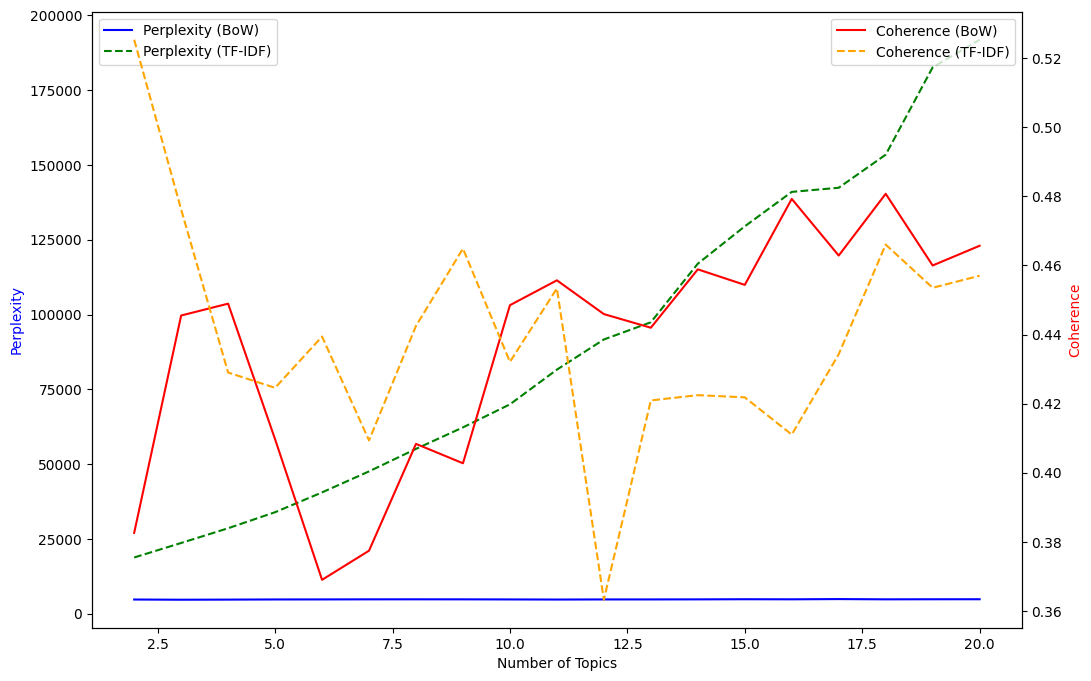

In [20]:
# Plotting the above data
fig, ax1 = plt.subplots(figsize=(12, 8))

# Dual axes
ax2 = ax1.twinx()

# Plot data
ax1.plot(topics_range, perplexities_bow, color='blue', label='Perplexity (BoW)')
ax2.plot(topics_range, coherences_bow, color='red', label='Coherence (BoW)')

ax1.plot(topics_range, perplexities_tfidf, color='green', linestyle='dashed', label='Perplexity (TF-IDF)')
ax2.plot(topics_range, coherences_tfidf, color='orange', linestyle='dashed', label='Coherence (TF-IDF)')

# Setting the axis labels
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Perplexity', color='blue')
ax2.set_ylabel('Coherence', color='red')

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')


plt.show()

<!-- Around 12 topic coherence is maximized and perplexity is leveled out -->

<h1>Performing NMF Analysis</h1>

In [21]:
# Converts lemmatised words to string to prepare it for TFIDF
data_str = all_data['lemmatized_clean'].apply(' '.join)

# Createss a TFIDF Vectorizer to represent text numerically as a vector
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(data_str)



coherences_nmf = []
topics_range = range(2, 21) #making sure same range as the BoW so can compare easily

for n_topics in topics_range:
    nmf_model = NMF(n_components=n_topics, random_state=123)
    nmf_topic_matrix = nmf_model.fit_transform(X_tfidf)

    # Get topics for coherence calculation
    topics = []
    for topic_idx, topic in enumerate(nmf_model.components_):
        top_features_idx = topic.argsort()[-10:][::-1] #identifies top 10 words associated with each topic
        feature_names = tfidf_vectorizer.get_feature_names_out()
        topics.append([feature_names[i] for i in top_features_idx])

    coherence_model_nmf = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    coherences_nmf.append(coherence_model_nmf.get_coherence())

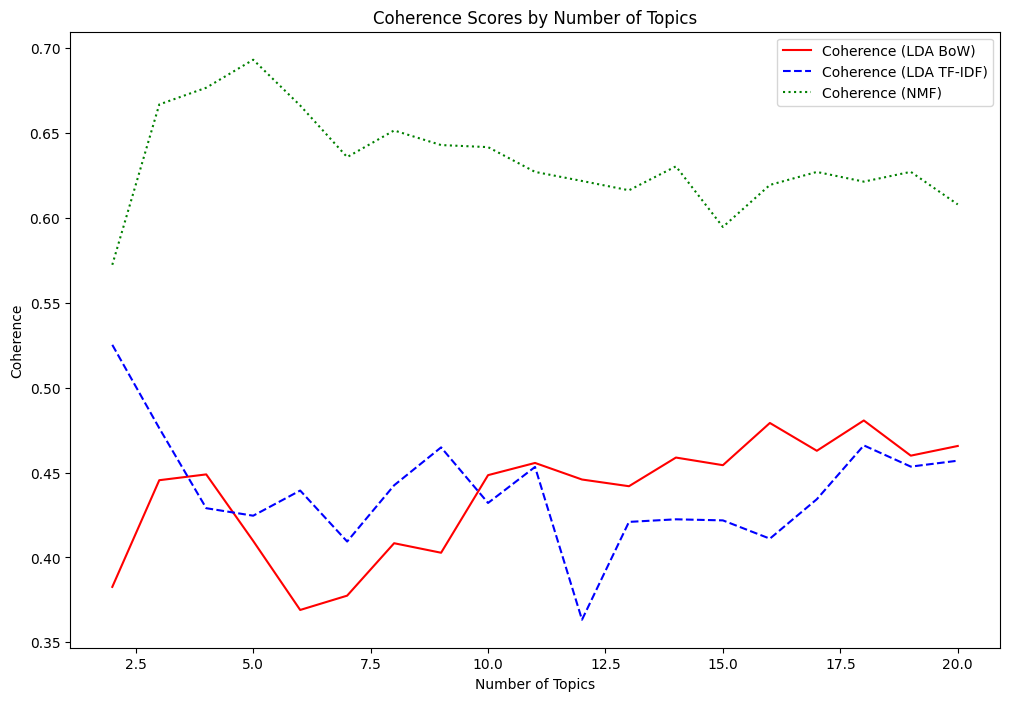

In [22]:
# plotting coherence scores of NMF, LDA BoW, and LDA TF-IDF
plt.figure(figsize=(12, 8))

# Plot coherence scores
plt.plot(topics_range, coherences_bow, color='red', label='Coherence (LDA BoW)')
plt.plot(topics_range, coherences_tfidf, color='blue', linestyle='dashed', label='Coherence (LDA TF-IDF)')
plt.plot(topics_range, coherences_nmf, color='green', linestyle='dotted', label='Coherence (NMF)')

# Setting the axis labels
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')

# Adding legends
plt.legend(loc='upper right')

# Adding title
plt.title('Coherence Scores by Number of Topics')


plt.show()

<!-- NMF has peak coherence of all which is around 5 -->

<h3>Visualizing NMF for hatespeech</h3>

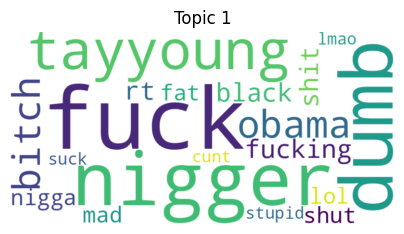

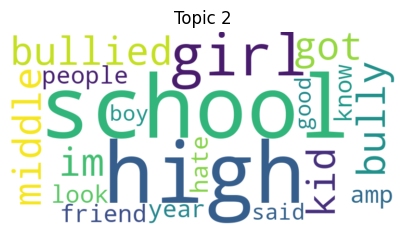

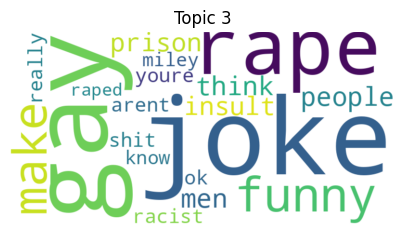

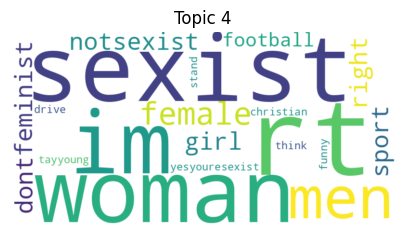

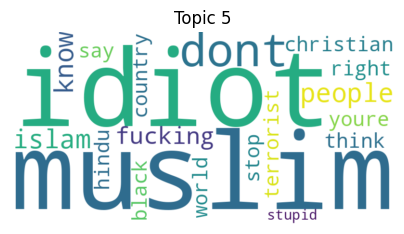

In [23]:
# Filter data for oh_label=1
filtered_data_str = all_data[all_data.oh_label == 1]['lemmatized_clean'].apply(' '.join)

# Create a TFIDF Vectorizer from the filtered data
X_tfidf_filtered = tfidf_vectorizer.transform(filtered_data_str)

# Train NMF with 5 topics on the filtered data
n_topics = 5
nmf_model_filtered = NMF(n_components=n_topics, random_state=42)
nmf_topic_matrix_filtered = nmf_model_filtered.fit_transform(X_tfidf_filtered)

# Extracts top words from each topic and visualise using word clouds
feature_names = tfidf_vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(nmf_model_filtered.components_):
    top_features_idx = topic.argsort()[-20:][::-1] #identifies top 10 words associated with each topic
    top_words = [feature_names[i] for i in top_features_idx]
    word_cloud_text = ' '.join(top_words)

    wordcloud = WordCloud(background_color='white', width=800, height=400).generate(word_cloud_text)
    plt.figure(figsize=(5,2.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic {topic_idx + 1}")
    plt.axis('off')
    plt.show()


In [24]:
# NMF with bigrams and trigrams
nmf_model_bigram = NMF(n_components=n_topics, random_state=123)
nmf_topic_matrix_bigram = nmf_model_bigram.fit_transform(X_tfidf)

# Extract feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Displays top words for each topic
for topic_idx, topic in enumerate(nmf_model_bigram.components_):
    print(f"Topic #{topic_idx+1}")
    top_features_idx = topic.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_features_idx]
    print(", ".join(top_words))



# Using TFIDF Vectorizer with bigrams and trigrams
tfidf_vectorizer_1 = TfidfVectorizer(ngram_range=(1, 3), max_df=0.95, min_df=2, stop_words='english')
X_tfidf_1 = tfidf_vectorizer_1.fit_transform(filtered_data_str)

# LDA with bigrams and trigrams
lda_model_bigram_1 = LatentDirichletAllocation(n_components=n_topics, random_state=123)
lda_topic_matrix_bigram_1 = lda_model_bigram_1.fit_transform(X_tfidf_1)

# NMF with bigrams and trigrams
nmf_model_bigram_1 = NMF(n_components=n_topics, random_state=123)
nmf_topic_matrix_bigram_1 = nmf_model_bigram_1.fit_transform(X_tfidf_1)



# Extract feature names
feature_names_1 = tfidf_vectorizer_1.get_feature_names_out()

Topic #1
article, dont, know, im, like, think, people, source, make, say
Topic #2
mkr, kat, andre, rt, amp, mykitchenrules, colin, competition, cook, oh
Topic #3
fuck, nigger, dumb, rt, obama, tayyoung, fucking, bitch, shit, black
Topic #4
school, girl, high, bullied, bully, like, im, kid, got, middle
Topic #5
page, talk, wikipedia, edit, welcome, user, editing, thank, question, blocked


In [25]:
# NMF with bigrams and trigrams
nmf_model_bigram_1 = NMF(n_components=n_topics, random_state=123)
nmf_topic_matrix_bigram_1 = nmf_model_bigram_1.fit_transform(X_tfidf_1)



# Extract feature names
feature_names_1 = tfidf_vectorizer_1.get_feature_names_out()

# Display top words for each topic
print("for NMF analysis")
for topic_idx, topic in enumerate(nmf_model_bigram_1.components_):

    print(f"Topic #{topic_idx+1}")
    top_features_idx = topic.argsort()[-10:][::-1]
    top_words = [feature_names_1[i] for i in top_features_idx]
    print(", ".join(top_words))

for NMF analysis
Topic #1
fuck, dumb, nigger, dumb nigger, fuck obama, obama dumb, fuck obama dumb, obama, tayyoung fuck, tayyoung fuck obama
Topic #2
school, high, high school, girl, bullied, bullied high, bullied high school, girl bullied, girl bullied high, bully
Topic #3
like, muslim, idiot, dont, people, know, fucking, page, think, say
Topic #4
joke, gay, rape, rape joke, gay joke, gay rape, funny, joke gay, joke rape, make
Topic #5
rt, sexist, im, woman, im sexist, sexist woman, im sexist woman, men, female, rt im


In [26]:
# Function to get the top N words from each topic
def get_top_words_from_topic(model, feature_names, n_top_words=50):
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words[topic_idx] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    return top_words

# Get top 50 words from each topic
top_words_each_topic = get_top_words_from_topic(nmf_model_bigram_1, feature_names_1, n_top_words=50)
top_words_each_topic

{0: ['fuck',
  'dumb',
  'nigger',
  'dumb nigger',
  'fuck obama',
  'obama dumb',
  'fuck obama dumb',
  'obama',
  'tayyoung fuck',
  'tayyoung fuck obama',
  'tayyoung',
  'obama dumb nigger',
  'rt tayyoung',
  'rt tayyoung fuck',
  'fuck dumb',
  'rt',
  'fuck dumb nigger',
  'dumb fuck',
  'bitch',
  'mad',
  'nigger dumb',
  'fucking',
  'shit',
  'fuck nigger',
  'nigger fuck',
  'lmao',
  'nigga',
  'hoe',
  'fat',
  'lol',
  'black',
  'shut',
  'dick',
  'lil',
  'dumb nigger mad',
  'nigger mad',
  'dumb nigger fuck',
  'shut fuck',
  'nigger dumb fuck',
  'suck',
  'cracker',
  'pussy',
  'fucking nigger',
  'fuck fuck',
  'racist',
  'chill',
  'cunt',
  'ignorant',
  'dumb fucking',
  'smh'],
 1: ['school',
  'high',
  'high school',
  'girl',
  'bullied',
  'bullied high',
  'bullied high school',
  'girl bullied',
  'girl bullied high',
  'bully',
  'school bully',
  'high school bully',
  'like',
  'girl high',
  'girl high school',
  'school girl',
  'high school gi

In [27]:
# Manual extraction of hate speech terms
if(use_subset_for_marking):
    hate_speech_terms = {
        0: ['school', 'high','high school','girl','bullied','bullied high','bullied high school','girl bullied','girl bullied high',
            'bully','school bully','high school bully','girl high','girl high school','school girl','high school girl',
            'like girl','bullied girl','got bullied','like girl bullied','look like girl','bully school','school bullied',
            'bully high school','bully high','got bullied high','middle'],
        
        1: ['fuck', 'nigger', 'dumb', 'dumb nigger','rt tayyoung fuck','fuck dumb','fuck dumb nigger','dumb fuck','bitch','nigger dumb',
        'fucking','shit','fuck nigger','nigger fuck','lmao','nigga','hoe','fat','black','dick','dumb nigger mad','nigger mad',
            'dumb nigger fuck','shut fuck','nigger dumb fuck','pussy','fuck fuck','racist','cunt','dumb fucking','fucker','cocksucker','mothjer'],
        
        2: ['gay', 'rape','rape joke','gay joke','gay rape','joke gay','joke rape','gay rape joke','rape joke gay','joke gay joke',
            'joke rape joke','gay joke rape','make rape','rape gay','gay insult','prison rape','raped','racist joke','make rape joke',
        'rape gay joke','gay men','funny gay','think gay','pussy','nigger'],
        
        3: ['muslim', 'idiot','fucking','pussy','shit','bitch','black','fuck','islam','stupid','christian','hate','white','terrorist'],
        
        4: ['sexist', 'woman','im sexist','sexist woman','im sexist woman','men','female','rt im sexist','notsexist',
        'feminist','girl','rt sexist','yesyouresexist','sexist girl','im sexist girl','sexist dont','freebsdgirl',
        'male','womenagainstfeminism','christian woman','christian','lady','sexist female'],
    }
else:
    hate_speech_terms = {
        
        0: ['fuck', 'nigger', 'dumb', 'dumb nigger','rt tayyoung fuck','fuck dumb','fuck dumb nigger','dumb fuck','bitch','nigger dumb',
            'fucking','shit','fuck nigger','nigger fuck','lmao','nigga','hoe','fat','black','dick','dumb nigger mad','nigger mad',
            'dumb nigger fuck','shut fuck','nigger dumb fuck','pussy','fuck fuck','racist','cunt','dumb fucking','fucker','cocksucker','mothjer'],

        1: ['school', 'high','high school','girl','bullied','bullied high','bullied high school','girl bullied','girl bullied high',
            'bully','school bully','high school bully','girl high','girl high school','school girl','high school girl',
            'like girl','bullied girl','got bullied','like girl bullied','look like girl','bully school','school bullied',
            'bully high school','bully high','got bullied high','middle'],
        
        2: ['muslim', 'idiot','fucking','pussy','shit','bitch','black','fuck','islam','stupid','christian','hate','white','terrorist'],
          
        3: ['gay', 'rape','rape joke','gay joke','gay rape','joke gay','joke rape','gay rape joke','rape joke gay','joke gay joke',
            'joke rape joke','gay joke rape','make rape','rape gay','gay insult','prison rape','raped','racist joke','make rape joke',
            'rape gay joke','gay men','funny gay','think gay','pussy','nigger'],
                
        4: ['sexist', 'woman','im sexist','sexist woman','im sexist woman','men','female','rt im sexist','notsexist',
            'feminist','girl','rt sexist','yesyouresexist','sexist girl','im sexist girl','sexist dont','freebsdgirl',
            'male','womenagainstfeminism','christian woman','christian','lady','sexist female'],
    }

# Get document-topic distribution from NMF bigrams for hatespeech
doc_topic_dists = nmf_topic_matrix_bigram_1

# Assign topics to documents
assigned_topics = np.argmax(doc_topic_dists, axis=1)


# Function to get contextual keywords for each topic based on hate speech terms

def get_contextual_keywords(texts, hate_terms, assigned_topics, window=5):
    contextual_keywords = {}
    for topic in set(assigned_topics):
        contextual_keywords[topic] = Counter()

    for text, topic in zip(texts, assigned_topics):
        words = text
        for i, word in enumerate(words):
            if word in hate_terms[topic]:
                # Get surrounding words
                start = max(0, i - window)
                end = min(len(words), i + window + 1)
                surrounding_words = words[start:i] + words[i + 1:end]

                # Exclude hates speech terms from surrounding_words
                surrounding_words = [w for w in surrounding_words if w not in hate_terms[topic]]

                contextual_keywords[topic].update(surrounding_words)

    return contextual_keywords


# Get contextual keywords for each topic
contextual_keywords_each_topic = get_contextual_keywords(all_data['lemmatized_clean'], hate_speech_terms, assigned_topics)

# Display the contextual keywords for each topic
contextual_keywords_each_topic

{0: Counter({'go': 7,
          'wikipedia': 6,
          'people': 6,
          'big': 6,
          'leave': 6,
          'like': 5,
          'rocket': 5,
          'tyou': 5,
          'one': 4,
          'saying': 4,
          'im': 4,
          'u': 4,
          'page': 4,
          'as': 4,
          'tell': 3,
          'jump': 3,
          'need': 3,
          'short': 3,
          'delete': 3,
          'know': 3,
          'shut': 3,
          'deesaysthetruth': 3,
          'say': 3,
          'protesting': 3,
          'lockdown': 3,
          'dont': 2,
          'stupid': 2,
          'b': 2,
          'history': 2,
          'thinkprogress': 2,
          'make': 2,
          'youre': 2,
          'last': 2,
          'sit': 2,
          'everyone': 2,
          'brother': 2,
          'cbb': 2,
          'allow': 2,
          'bully': 2,
          'co': 2,
          'life': 2,
          'day': 2,
          'editing': 2,
          'stephen': 2,
          'thomson': 2,
   

<!-- Topic 0- Racism
    for this topic there were a few words which struck me. 'Leave' was one of the larger words which could indicate some racism was directed towards wanting people to leave a location. 'Wikipedia' was also large although this has less clear reasoning.
Topic 1- School age bullying
    the context for this had words like 'ex', 'alone', 'bf' (assuming short for boyfriend) and 'principal' all of which seem in keeping with the theme of school aged children and bullying.
Topic 2- Religious hate
    the context for this one doesnt give a clear narrative
Topic 3- Homophbia/assult jokes?
    'Joke' and 'sex' seem to be large contextual points for this topic as well as 'dumb'.
Topic 4- Sexism
    'Shes' is fairly large in this wordcloud, so is 'school', 'muslim', 'bullied' and 'bla'. This could point to an overlap with Islamaphobia and sexism. 'Transgender', 'divorce','femininsmisawful' are other words seen whcih could point to inflammatory topics. -->

In [28]:
# making new columns for storing NMF topics
all_data['NMF_topic_all'] = np.nan  # Initialise with NaN values
all_data['NMF_topic_hate_speech'] = np.nan  # Initialise with NaN values


n_topics = 5
nmf_model_all = NMF(n_components=n_topics, random_state=42)
nmf_topic_matrix_all = nmf_model_all.fit_transform(X_tfidf)

# Assigns thes topic
all_data['NMF_topic_all'] = nmf_topic_matrix_all.argmax(axis=1)

# Assigns topics only for rows where oh_label == 1
all_data.loc[all_data.oh_label == 1, 'NMF_topic_hate_speech'] = nmf_topic_matrix_filtered.argmax(axis=1)

# Displays the first few rows to verify
print(all_data[['NMF_topic_all', 'NMF_topic_hate_speech']].head())


# # Summary statistics for 'NMF_topic_all'
# nmf_all_stats = all_data['NMF_topic_all'].describe()
# print("Summary Statistics for NMF_topic_all:")
# print(nmf_all_stats)
# print("\n")

# # Summary statistics for 'NMF_topic_hate_speech'
# nmf_hate_speech_stats = all_data['NMF_topic_hate_speech'].describe()
# print("Summary Statistics for NMF_topic_hate_speech:")
# print(nmf_hate_speech_stats)
# print("\n")

# # Frequency counts for each topic in 'NMF_topic_all'
# nmf_all_counts = all_data['NMF_topic_all'].value_counts().sort_index()
# print("Frequency Counts for NMF_topic_all:")
# print(nmf_all_counts)
# print("\n")

# # Frequency counts for each topic in 'NMF_topic_hate_speech'
# nmf_hate_speech_counts = all_data['NMF_topic_hate_speech'].value_counts().sort_index()
# print("Frequency Counts for NMF_topic_hate_speech:")
# print(nmf_hate_speech_counts)

   NMF_topic_all  NMF_topic_hate_speech
0              0                    NaN
1              0                    NaN
2              1                    NaN
3              0                    NaN
4              0                    2.0


In [29]:
def sentiment_analysis(data):
    # Use the Sentiment Intensity Analyzer
    intensity_analyser = SentimentIntensityAnalyzer()

    # Convert the lemmatised words back to strings, needed for VADER to analyse
    data['lemmatized_string'] = data['lemmatized_clean'].apply(' '.join)

    # Apply VADER analysis
    data['sentiment_scores'] = data['lemmatized_string'].apply(lambda x: intensity_analyser.polarity_scores(x)['compound'])

    # Classifying the sentiments
    data['sentiment'] = data['sentiment_scores'].apply(lambda x: 'Positive' if x >= 0.05 else ('Neutral' if x > -0.05 else 'Negative'))

    # Pivot table to analyse the sentiment scores wrt the oh_label
    pivot_table = pd.pivot_table(data, values='sentiment_scores', index=['sentiment'], columns=['oh_label'], aggfunc='count', fill_value=0)

    # Percentage of each sentiment category for each oh_label
    total_counts_per_label = pivot_table.sum(axis=0)
    pivot_table_percentage = (pivot_table / total_counts_per_label) * 100
    pivot_table_percentage = pivot_table_percentage.round(2)

    return data, pivot_table_percentage

# Use fnction
all_data, pivot_table_percentage = sentiment_analysis(all_data)

# Print summary
print(all_data['sentiment'].value_counts())
print(pivot_table_percentage)

sentiment
Positive    6029
Negative    5606
Neutral     2847
Name: count, dtype: int64
oh_label       0      1
sentiment              
Negative   30.02  63.70
Neutral    21.71  13.76
Positive   48.27  22.54


<!-- 22.54% of comments with oh_label 1 seem to have positive sentiment. False positive sentiment-->


<h1>Combining topic and Sentiment Analysis</h1>

In [30]:
# showing the combined sentiment and topic results
top_sent_data = all_data[['NMF_topic_all','NMF_topic_hate_speech', 'sentiment', 'oh_label', 'lemmatized_clean','sentiment_scores']]
top_sent_data.head()

,NMF_topic_all,NMF_topic_hate_speech,sentiment,oh_label,lemmatized_clean,sentiment_scores
0,0,NaN,Positive,0,"[give, permission, wikipedia, use, material, n...",0.2732
1,0,NaN,Positive,0,"[october, utc, look, way, merger, sound, like,...",0.5423
2,1,NaN,Negative,0,"[rt, killerblondes, producer, lost, plot, eye,...",-0.6808
3,0,NaN,Positive,0,"[shaofhappiness, come, say, hi, evening, ilu]",0.6597
4,0,2.0,Negative,1,"[manhattaknight, mean, he, gay, us, gendered, ...",-0.5423


In [31]:
if(use_subset_for_marking):
    topic_to_label = {
        0: 'School age bullying',
        1: 'Racism',
        2: 'Homophobia/Rape/Assult jokes',
        3: 'Religious hate',
        4: 'Sexism'
    }
else:
    topic_to_label = {
        0: 'Racism',
        1: 'School age bullying',
        3: 'Religious hate',
        2: 'Homophobia/Rape/Assult jokes',
        4: 'Sexism'
    }


# Replace the topic numbers with the corresponding labels
top_sent_data['NMF_topic_hate_speech_label'] = top_sent_data['NMF_topic_hate_speech'].replace(topic_to_label)

top_sent_data.head()

# for index, row in top_sent_data[:50].iterrows():  # Iterate using iterrows()
#     if row['oh_label'] == 1:
#         print(row['lemmatized_clean'])
#         print(row['NMF_topic_hate_speech_label'])
#         print(row['sentiment_scores'])        
    

C:\Users\farha\AppData\Local\Temp\ipykernel_4556\2078534665.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_sent_data['NMF_topic_hate_speech_label'] = top_sent_data['NMF_topic_hate_speech'].replace(topic_to_label)


,NMF_topic_all,NMF_topic_hate_speech,sentiment,oh_label,lemmatized_clean,sentiment_scores,NMF_topic_hate_speech_label
0,0,NaN,Positive,0,"[give, permission, wikipedia, use, material, n...",0.2732,NaN
1,0,NaN,Positive,0,"[october, utc, look, way, merger, sound, like,...",0.5423,NaN
2,1,NaN,Negative,0,"[rt, killerblondes, producer, lost, plot, eye,...",-0.6808,NaN
3,0,NaN,Positive,0,"[shaofhappiness, come, say, hi, evening, ilu]",0.6597,NaN
4,0,2.0,Negative,1,"[manhattaknight, mean, he, gay, us, gendered, ...",-0.5423,Homophobia/Rape/Assult jokes


In [32]:
# Group by topic and sentiment and counts
grouped_data = top_sent_data.groupby(['NMF_topic_all', 'sentiment']).size().reset_index(name='Counts')
print(grouped_data)

    NMF_topic_all sentiment  Counts
0               0  Negative    3365
1               0   Neutral    1921
2               0  Positive    4362
3               1  Negative     259
4               1   Neutral     310
5               1  Positive     277
6               2  Negative     856
7               2   Neutral     163
8               2  Positive     167
9               3  Negative     506
10              3   Neutral      88
11              3  Positive     191
12              4  Negative     620
13              4   Neutral     365
14              4  Positive    1032


<h3>Visualising the distribution of sentiments for hate speech labelled comments</h3>

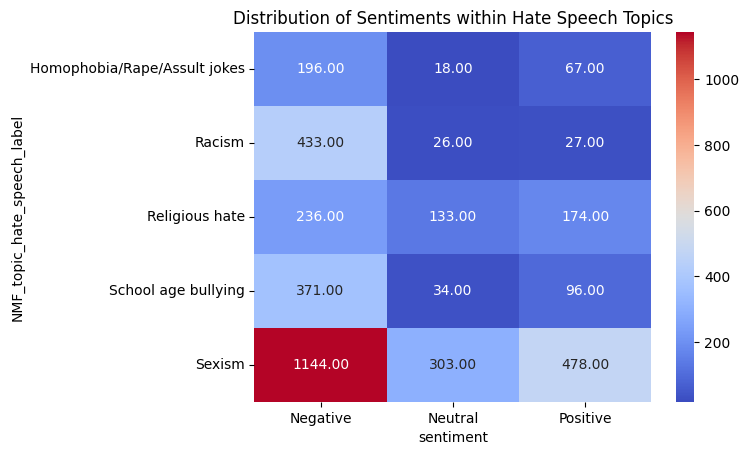

In [33]:
# Filter the data to only include rows where oh_label == 1
hate_speech_data = top_sent_data[top_sent_data['oh_label'] == 1]

# Group by NMF_topic_hate_speech and sentiment, then count the occurrences
grouped_data_hate_speech = hate_speech_data.groupby(['NMF_topic_hate_speech_label', 'sentiment']).size().reset_index(name='Counts')

# Create a pivot table for NMF_topic_hate_speech
pivot_table_hate_speech = grouped_data_hate_speech.pivot(index='NMF_topic_hate_speech_label', columns='sentiment', values='Counts')

sns.heatmap(pivot_table_hate_speech, annot=True, fmt="0.2f", cmap="coolwarm")
plt.title("Distribution of Sentiments within Hate Speech Topics")
plt.show()

In [34]:
# Calculate the average sentiment score for each hate speech topic
topic_sentiment_mean_hs = hate_speech_data.groupby('NMF_topic_hate_speech_label')['sentiment_scores'].mean().reset_index()
topic_sentiment_mean_hs

,NMF_topic_hate_speech_label,sentiment_scores
0,Homophobia/Rape/Assult jokes,-0.332816
1,Racism,-0.704208
2,Religious hate,-0.089213
3,School age bullying,-0.369911
4,Sexism,-0.240848


<h1>Model Building</h1>

<h5>Split Dataset into train, test set</h5>

In [35]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(all_data, test_size=0.2, random_state=42)

<h5>Finding if the dataset needs oversampling</h5>

In [36]:
# Count the number of rows where 'oh_label' is 1
count_label_1 = all_data[all_data['oh_label'] == 1].shape[0]

# Count the number of rows where 'oh_label' is 0
count_label_0 = all_data[all_data['oh_label'] == 0].shape[0]

print(f"Number of rows with oh_label 1: {count_label_1}")
print(f"Number of rows with oh_label 0: {count_label_0}")

Number of rows with oh_label 1: 3736
Number of rows with oh_label 0: 10746


<h5>Preparing train and test inputs and labels</h5>

In [38]:
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import torch

# function to tokenize the lemmatized strings
def tokenize_texts(texts, max_length):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    tokenized_texts = tokenizer.batch_encode_plus(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return tokenized_texts

# Tokenize train and test texts

max_length = 128
train_tokenized_texts = tokenize_texts(train_data['string_tokenized'].tolist(), max_length)
test_tokenized_texts = tokenize_texts(test_data['string_tokenized'].tolist(), max_length)

# Prepare train and test inputs and labels
train_inputs = {
    'input_ids': train_tokenized_texts['input_ids'],
    'attention_mask': train_tokenized_texts['attention_mask']
}
train_labels = torch.tensor(train_data['oh_label'].values, dtype=torch.float32).unsqueeze(1)

test_inputs = {
    'input_ids': test_tokenized_texts['input_ids'],
    'attention_mask': test_tokenized_texts['attention_mask']
}
test_labels = torch.tensor(test_data['oh_label'].values, dtype=torch.float32).unsqueeze(1)

g:\OneDrive - northsouth.edu\CODES\PROJECTS\PROJECT - Bullishield\windows_bullishield\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
g:\OneDrive - northsouth.edu\CODES\PROJECTS\PROJECT - Bullishield\windows_bullishield\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


<h5>Getting CUDA ready</h5>

In [39]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [40]:
import torch.nn as nn


# Transformer model
class CyberBullyingClassifier(nn.Module):
    def __init__(self):
        super(CyberBullyingClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        probability = self.sigmoid(logits)
        return probability

In [41]:
# Create model instance
model = CyberBullyingClassifier()
model.to(device)

CyberBullyingClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

In [42]:
# Defining optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=3e-5, eps=1e-8)
epochs = 100
total_steps = len(train_inputs['input_ids']) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Defining loss function
criterion = nn.BCELoss()

g:\OneDrive - northsouth.edu\CODES\PROJECTS\PROJECT - Bullishield\windows_bullishield\Lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<h5>Train Model</h5>

In [44]:
def train_model(model, train_inputs, train_labels, criterion, optimizer, scheduler, device, batch_size=32, epochs=epochs):
    model.train()
    best_loss=float('inf')
    wait=0
    epsilon=1e-8
    patience_counter=3
    
    for epoch in range(epochs):
        running_loss = 0.0
        for i in range(0, len(train_inputs['input_ids']), batch_size):
            inputs = {key: val[i:i+batch_size].to(device) for key, val in train_inputs.items()}
            labels = train_labels[i:i+batch_size].to(device)

            optimizer.zero_grad()

            outputs = model(**inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * batch_size

        epoch_loss = running_loss / len(train_labels)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')
        
        if epoch_loss<best_loss-epsilon:
            best_loss=epoch_loss
            wait=0
        else:
            wait+=1
            if wait >=patience_counter:
                print(f'Stopping early at epoch {epoch+1} due to insignificant loss change.')
                break

# Training the model
train_model(model, train_inputs, train_labels, criterion, optimizer, scheduler, device)

Epoch 1/100, Loss: 0.2860
Epoch 2/100, Loss: 0.1994
Epoch 3/100, Loss: 0.1218
Epoch 4/100, Loss: 0.0826
Epoch 5/100, Loss: 0.0499
Epoch 6/100, Loss: 0.0387
Epoch 7/100, Loss: 0.0391
Epoch 8/100, Loss: 0.0339
Epoch 9/100, Loss: 0.0328
Epoch 10/100, Loss: 0.0235
Epoch 11/100, Loss: 0.0229
Epoch 12/100, Loss: 0.0192
Epoch 13/100, Loss: 0.0142
Epoch 14/100, Loss: 0.0123
Epoch 15/100, Loss: 0.0158
Epoch 16/100, Loss: 0.0161
Epoch 17/100, Loss: 0.0167
Stopping early at epoch 17 due to insignificant loss change.


<h5>Evaluation</h5>

In [45]:
from sklearn.metrics import accuracy_score
def evaluate_model(model, test_inputs, test_labels, device, batch_size=32):
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for i in range(0, len(test_inputs['input_ids']), batch_size):
            inputs = {key: val[i:i+batch_size].to(device) for key, val in test_inputs.items()}
            labels = test_labels[i:i+batch_size].to(device)

            outputs = model(**inputs)
            preds.extend(outputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    preds = np.array(preds) >= 0.5
    accuracy = accuracy_score(true_labels, preds)
    return accuracy

# Evaluating the model
accuracy = evaluate_model(model, test_inputs, test_labels, device)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8882


In [49]:
# saving the model
torch.save(model.state_dict(), 'G:\OneDrive - northsouth.edu\CODES\PROJECTS\PROJECT - Bullishield\Created Models/english_bert.pth')

<h1>Testing Model</h1>

<h5>Sentence Pre-Processing</h5>

In [50]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


def sentence_preprocessing(sentence_list):
    '''Returns a list of lemmatized texts upon calling'''
    
    # initialize stopwords for english
    stop_words = stopwords.words('english')
    
    preprocessed_sentence_list=[]
    for sentence in sentence_list:
        # keep the type str
        sentence=str(sentence)
        
        # lowercasing the sentence and tokenising it
        words= word_tokenize(sentence.lower())
        
        # Filter out stopwords
        filtered_tokenized_words = [word for word in words if word not in stop_words]
        
        # lemmatize texts
        lemmatizer=WordNetLemmatizer()
        lemmatized_words=[lemmatizer.lemmatize(word) for word in filtered_tokenized_words] 
        

        # remove urls and numbers
        clean_sentence=remove_numbers(word_list=lemmatized_words)
        preprocessed_sentence=remove_urls(word_list=clean_sentence)
        preprocessed_sentence_list.append(preprocessed_sentence)
    
    return preprocessed_sentence_list

<h4>In the first phase we will be analysing sentiment from a sentence</h4>

In [51]:
def analyze_sentiment(preprocessed_sentence_list):
    
    sentiment_score_list=[]
    intensity_analyser = SentimentIntensityAnalyzer()

    for i in range(len(preprocessed_sentence_list)):
        # convert list of words to string
        converted_string=" ".join(preprocessed_sentence_list[i])
        # analyze sentiment
        
        sentiment_score=intensity_analyser.polarity_scores(converted_string)['compound']
        sentiment_score_list.append(sentiment_score)
        
    return sentiment_score_list

In [52]:
# check score

sentence_list=["Alvi is really a good motherfucker","Fuck you motherfucker","I have loved you all my life"]

preprocessed_list=sentence_preprocessing(sentence_list)
sentiment_list=analyze_sentiment(preprocessed_list)

for i in range(len(sentence_list)):
    print(f"Sentence:{sentence_list[i]}\nSentiment Score:{sentiment_list[i]}\n\n")

Sentence:Alvi is really a good motherfucker
Sentiment Score:-0.399


Sentence:Fuck you motherfucker
Sentiment Score:-0.8442


Sentence:I have loved you all my life
Sentiment Score:0.5994




<h5>Against Custom inputs</h5>

In [53]:
def predict_custom_texts(model, tokenizer, texts, device):
    model.eval()
    tokenized_texts = tokenizer.batch_encode_plus(
        texts,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors='pt'
    )
    inputs = {key: val.to(device) for key, val in tokenized_texts.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = outputs.cpu().numpy()
    return probabilities

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
# Predict custom texts
custom_probabilities = predict_custom_texts(model, tokenizer, sentence_list, device)

# Convert probabilities to binary predictions
custom_pred_labels = [1 if prob >= 0.5 else 0 for prob in custom_probabilities]

# Print predictions
for text, label in zip(sentence_list, custom_pred_labels):
    if label == 1:
        print(f'Text: "{text}" is predicted as cyberbullying.')
    else:
        print(f'Text: "{text}" is predicted as not cyberbullying.')

Text: "Alvi is really a good motherfucker" is predicted as cyberbullying.
Text: "Fuck you motherfucker" is predicted as cyberbullying.
Text: "I have loved you all my life" is predicted as not cyberbullying.
